# Get the data using scrapper and save to file "data.csv"

In [ ]:
import arxivscraper
import pandas as pd
scraper = arxivscraper.Scraper(category='cs', date_from='2017-08-01',date_until='2018-08-01')
output = scraper.scrape()

cols = ['id', 'title', 'categories', 'abstract', 'doi', 'created', 'updated', 'authors']
df = pd.DataFrame(output, columns=cols)
df.to_csv('data.csv')

http://export.arxiv.org/oai2?verb=ListRecords&from=2017-08-01&until=2018-08-01&metadataPrefix=arXiv&set=cs
fetching up to  1000 records...


# import data from "data.csv" and filter for "math" category

In [149]:
import pandas as pd
import itertools
import ast
arxiv_df = pd.read_csv("data.csv")
print(arxiv_df.shape)
arxiv_df = arxiv_df[arxiv_df['categories'].str.contains("math")]
print(arxiv_df.shape)

(42988, 9)
(7838, 9)


# Generating edge list:

In [150]:
def generate_node_list(arxiv_df):
    authors_edge_list = []
    for x in list(arxiv_df['authors'].unique()):
#         Generating edge combinations from comma seperated list of authors
        for y in list(itertools.combinations(sorted(ast.literal_eval(x)),2)):
            authors_edge_list.append([x,y[0],y[1]])

    author_edges_df = pd.DataFrame.from_records(authors_edge_list)
    author_edges_df.columns = ['authors','author_x','author_y']
#     Merging the edge list back to original data
    merged_df = pd.merge(arxiv_df, author_edges_df, left_on='authors', right_on='authors')

    merged_df = merged_df[merged_df['author_x']!=merged_df['author_y']]

#     Assign weights to edges based on distinct number of publications authors' share (publication id is used)
    edgeList_df = merged_df.groupby(['author_x','author_y']).agg({"id": lambda x: x.nunique()}).reset_index()
    edgeList_df.columns = ['author_x','author_y','weight']

#     Finally returning data frame with edges and weights
    return edgeList_df

# Generating Graph for all the authors:

In [151]:
import networkx as nx
import matplotlib.pyplot as plt
All_Node_Graph = nx.Graph()

In [152]:
All_Edges = generate_node_list(arxiv_df) # calling the function to generate edge-weight list
All_Nodes = set(list(All_Edges["author_x"]))
All_Nodes.update(list(All_Edges["author_y"]))

print("No. Of Nodes:" + str(len(All_Nodes)))
print("No. Of Edges:" + str(All_Edges.shape[0]))


No. Of Nodes:8232
No. Of Edges:22260


<b> Add Nodes and Edges to Graph </b>

In [153]:
All_Node_Graph.add_nodes_from(list(All_Nodes))
All_Node_Graph.add_weighted_edges_from(list(All_Edges.itertuples(index=False)))

In [154]:
# Filtering for nodes with neighbor count between 10-15, also adding all its neighbors to the final list
Final_Nodes = set([])
for eachNode in All_Node_Graph.nodes:
    if 10<=(len(list(All_Node_Graph.neighbors(eachNode))))<=15:
        Final_Nodes.add(eachNode)
        Final_Nodes.update(All_Node_Graph.neighbors(eachNode))
    if len(Final_Nodes)>200:
        break
    else:
        continue

In [155]:
# Generating a new graph from the list of nodes identified in previous step. This reduces the size of our graph
# All the edges between these nodes are also added to the "New_Graph"
New_Graph = All_Node_Graph.subgraph(Final_Nodes)

# Save the graph to Gephi 

In [156]:
# Saving the graph to gephi format for better visualization
nx.write_gexf(New_Graph, "gephiGraph.gexf")

# Degree Distribution:

Text(0.5,0,'Degree')

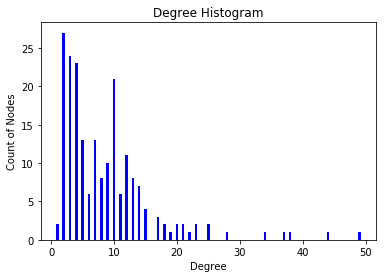

In [157]:
import collections
degree_sequence = sorted([d for n, d in New_Graph.degree()], reverse=True)  # degree sequence
# print "Degree sequence", degree_sequence
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())


fig, ax = plt.subplots()
plt.bar(deg, cnt, width=0.40, color='b')

plt.title("Degree Histogram")
plt.ylabel("Count of Nodes")
plt.xlabel("Degree")

# nx.average_degree_connectivity(New_Graph)

# Clustering Co-efficient

In [158]:
def dictionary_to_listOfCounts(dict):
    List = []
    for key, value in dict.items():
        if isinstance(key, float):
            x = round(key, 4)
            temp = [x,value]
            List.append(temp)
        else:
            temp = [key,value]
            List.append(temp)

    sequence = sorted([d for n, d in List], reverse=True)  # degree sequence
    valueCount = collections.Counter(sequence)
    values, cnt = zip(*valueCount.items())
    return values, cnt

Average Clustering co-efficient of graph is: 0.768721




Text(0.5,0,'Clustering co-efficient')

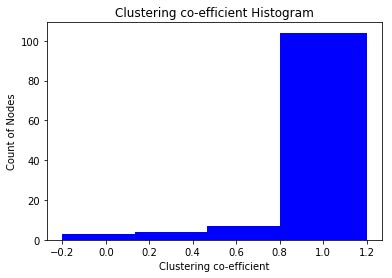

In [159]:
print("Average Clustering co-efficient of graph is: %f\n\n" % nx.average_clustering(New_Graph))

cluster, cnt = dictionary_to_listOfCounts(nx.clustering(New_Graph))

fig, ax = plt.subplots()
plt.bar(cluster, cnt, width=0.40, color='b')

plt.title("Clustering co-efficient Histogram")
plt.ylabel("Count of Nodes")
plt.xlabel("Clustering co-efficient")

# Diameter

Not a connected graph. Finding diameter for each connected sub-graph
6
3


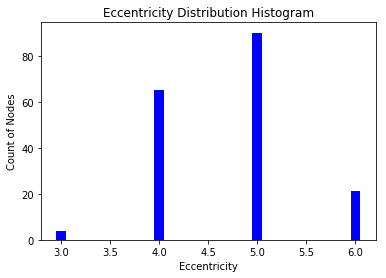

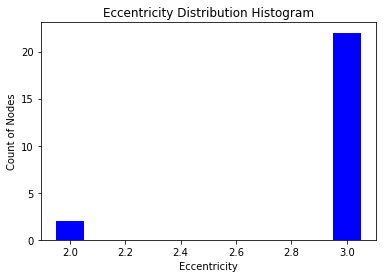

In [160]:
if(nx.is_connected(New_Graph)):
    print("Diameter of entire network is: " +str(nx.diameter(New_Graph)))
else:
    print("Not a connected graph. Finding diameter for each connected sub-graph")
    i = 0;
    for component in nx.connected_component_subgraphs(New_Graph):
        print(nx.diameter(component))
        eccentricity, cnt = dictionary_to_listOfCounts(nx.eccentricity(component))
        i = i+1
        fig, ax = plt.subplots()
        plt.bar(eccentricity, cnt, width=0.10, color='b')

        plt.title("Eccentricity Distribution Histogram")
        plt.ylabel("Count of Nodes")
        plt.xlabel("Eccentricity")

# Closeness

Text(0.5,0,'Closeness')

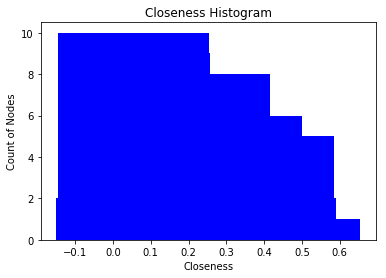

In [161]:
# closeness = nx.closeness_centrality(New_Graph)

closeness, cnt = dictionary_to_listOfCounts(nx.closeness_centrality(New_Graph))

fig, ax = plt.subplots()
plt.bar(closeness, cnt, width=0.40, color='b')

plt.title("Closeness Histogram")
plt.ylabel("Count of Nodes")
plt.xlabel("Closeness")


# Betweenness of Nodes

Text(0.5,0,'Betweenness')

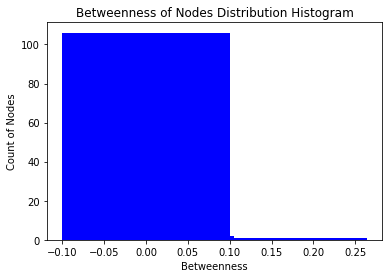

In [162]:
betweenness, cnt = dictionary_to_listOfCounts(nx.betweenness_centrality(New_Graph))

fig, ax = plt.subplots()
plt.bar(betweenness, cnt, width=0.20, color='b')

plt.title("Betweenness of Nodes Distribution Histogram")
plt.ylabel("Count of Nodes")
plt.xlabel("Betweenness")

# betweenness = nx.betweenness_centrality(New_Graph)

# d_view = [ (v,k) for k,v in betweenness.items() ]
# d_view.sort(reverse=True) # natively sort tuples by first element
# print(color.BOLD + 'Betweenness of Nodes' + color.END)
# for v,k in d_view:
#     print("%s: %f" % (k,v))

# Betweenness of edges

Text(0.5,0,'Betweenness')

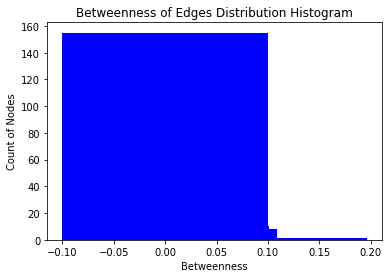

In [163]:
edge_betweenness, cnt = dictionary_to_listOfCounts(nx.edge_betweenness_centrality(New_Graph))

fig, ax = plt.subplots()
plt.bar(edge_betweenness, cnt, width=0.20, color='b')

plt.title("Betweenness of Edges Distribution Histogram")
plt.ylabel("Count of Nodes")
plt.xlabel("Betweenness")

# edge_betweenness = nx.edge_betweenness_centrality(New_Graph)

# d_view = [ (v,k) for k,v in edge_betweenness.items() ]
# d_view.sort(reverse=True) # natively sort tuples by first element
# print(color.BOLD + 'Betweenness of Edges' + color.END)
# for v,k in d_view:
#     print("%s: %f" % (k,v))

# Hits

Text(0.5,0,'Hits')

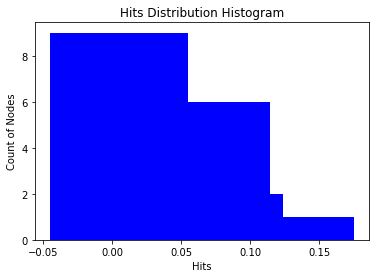

In [164]:
hits, cnt = dictionary_to_listOfCounts(nx.hits(component, max_iter=100, tol=1e-04)[0])
i = i+1
fig, ax = plt.subplots()
plt.bar(hits, cnt, width=0.10, color='b')

plt.title("Hits Distribution Histogram")
plt.ylabel("Count of Nodes")
plt.xlabel("Hits")

# nx.hits(New_Graph, max_iter=100, tol=1e-04)[1]

# Visualizing graph

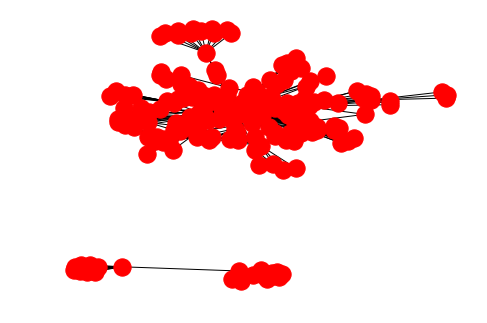

In [165]:
nx.draw(New_Graph)